# Random Forest Classification

In [417]:
# Loading in dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

In [418]:
# Reading in the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## **Data Preprocessing**

In [461]:
# Load dependencies
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder

In [462]:
train_encoded = train.copy()
test_encoded = test.copy()

# List of numeric variables
numeric_vars = ['AI_Interaction_Level', 'Age', 'Satisfaction_with_AI_Services',
                'AI_Personalization_Effectiveness', 'Overall_Usage_Frequency',
                'Customer_Service_Interactions', 'Change_in_Usage_Patterns']

# Confirm all numeric variables are of numeric type
train_encoded[numeric_vars] = train_encoded[numeric_vars].apply(pd.to_numeric, errors='coerce')
test_encoded[numeric_vars] = test_encoded[numeric_vars].apply(pd.to_numeric, errors='coerce')

### **Data Standardization**

Standardization models all features to have a mean of 0 and a standard deviation of 1. This method most benefits SVM and Logistic Regression models.

In [463]:
# Initializing the scaler
scaler = StandardScaler()

train_encoded_standardized = train_encoded.copy()
test_encoded_standardized = test_encoded.copy()

# Apply standardization

columns_to_standardize = ['AI_Interaction_Level','Age','Satisfaction_with_AI_Services', 
                        'AI_Personalization_Effectiveness', 'Overall_Usage_Frequency', 
                        'Customer_Service_Interactions', 'Change_in_Usage_Patterns']
train_encoded_standardized[columns_to_standardize] = scaler.fit_transform(train_encoded_standardized[columns_to_standardize])
test_encoded_standardized[columns_to_standardize] = scaler.fit_transform(test_encoded_standardized[columns_to_standardize])

### **Data Normalization**

Normalization changes the values of the features in the dataset to a common scale, without distorting differences in the ranges of values or losing information. MinMaxScaler in particular, scales all these features to fit in a [0,1] interval.

In [464]:
# Initialize the MinMaxScaler for normalization
scaler = MinMaxScaler()

train_encoded_normalized = train_encoded.copy()
test_encoded_normalized = test_encoded.copy()

columns_to_normalize = ['AI_Interaction_Level','Age','Satisfaction_with_AI_Services', 
                        'AI_Personalization_Effectiveness', 'Overall_Usage_Frequency', 
                        'Customer_Service_Interactions', 'Change_in_Usage_Patterns']
train_encoded_normalized[columns_to_normalize] = scaler.fit_transform(train_encoded_normalized[columns_to_normalize])
train_encoded_normalized[columns_to_normalize] = scaler.fit_transform(train_encoded_normalized[columns_to_normalize])

### **Correlation Matrix**

Taken from the initial EDA, we created a correlation matrix as follows:

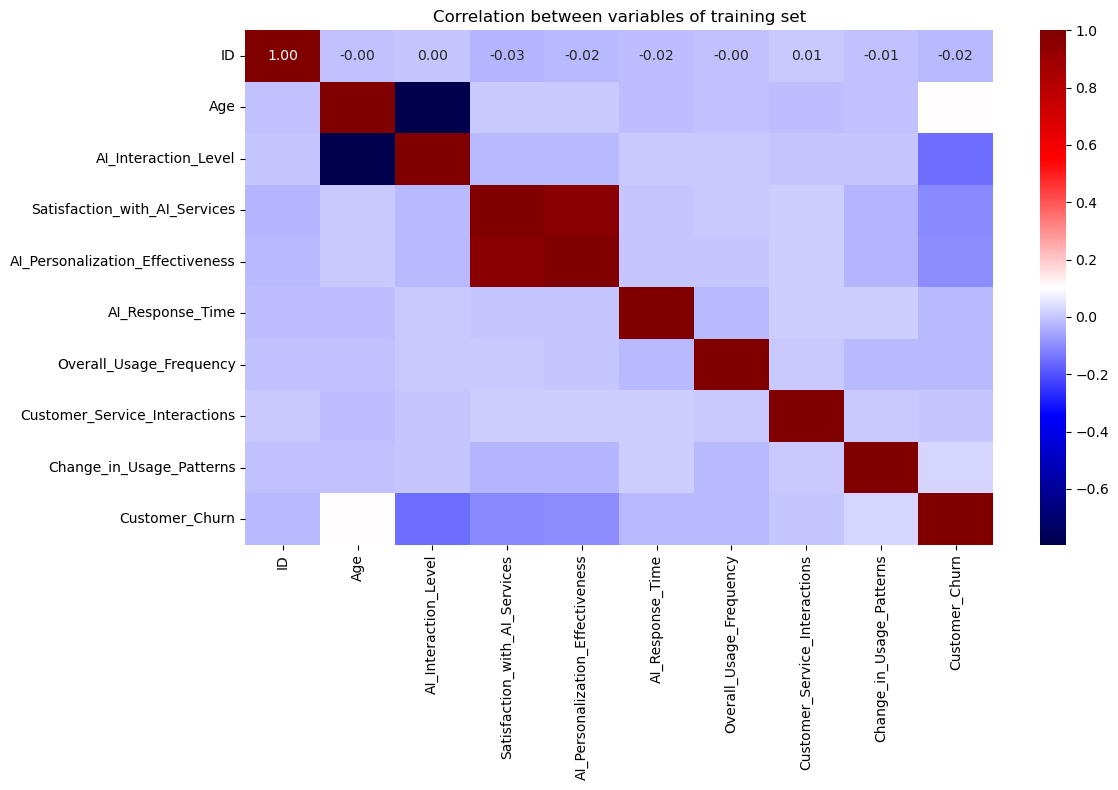

In [465]:
# Plotting correlation matrix
correlation_matrix = train_encoded.corr()

plt.figure(figsize=(12, 8))

# Drawing heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='seismic',
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns)
plt.title("Correlation between variables of training set")

plt.tight_layout()
plt.show()

## **Feature Engineering**

We combine relevant features into interaction features.

#### 1 | Age & AI Interaction Level

Age and AI interaction level are strongly negatively correlated (-0.79), and display considerable correlation with customer churn (0.11 and -0.15 respectively) Creating this interaction feature aims to uncover non-linear trends that can come about from considering both features heavily.

In [466]:
import pandas as pd

train_encoded_fe = train_encoded.copy()
test_encoded_fe = test_encoded.copy()

train_encoded_fe['Age_AI_Interaction'] = train_encoded['Age'] * train_encoded['AI_Interaction_Level']
test_encoded_fe['Age_AI_Interaction'] = test_encoded['Age'] * test_encoded['AI_Interaction_Level']

#### 2 | Satisfaction with AI Services & AI Personalization Effectiveness

These two features display high colinearrity: 0.96. This may become a problem as considering both features does not bear significant advantages for predicting customer churn compared to simply predicting either one. 

In [467]:
train_encoded_fe['Overall_Satisfaction'] = (train_encoded_fe['Satisfaction_with_AI_Services'] + train_encoded_fe['AI_Personalization_Effectiveness']) / 2
test_encoded_fe['Overall_Satisfaction'] = (test_encoded_fe['Satisfaction_with_AI_Services'] + test_encoded_fe['AI_Personalization_Effectiveness']) / 2

In [468]:
# We remove the previous 2 features
train_encoded_fe.drop(columns = ['Satisfaction_with_AI_Services', 'AI_Personalization_Effectiveness'], inplace=True)
test_encoded_fe.drop(columns = ['Satisfaction_with_AI_Services', 'AI_Personalization_Effectiveness'], inplace=True)

#### 3 | Polynomial Features

We tried using polynomial features for age and overall usage frequency as they are continuous variables, but replacing the continuous variables with polynomial features (squared) were detrimental to our model's accuracy, and hence we removed these features.

#### 4 | Dropping Overscaled features

Similarly, from analysing the feature importances, we noticed that the overall usage frequency had too much weight in the model's prediction; removing this feature however seemingly influenced the model negatively.

In [469]:
# train_encoded_fe.drop(columns = ['Overall_Usage_Frequency'], inplace=True)
# test_encoded_fe.drop(columns = ['Overall_Usage_Frequency'], inplace=True)

## **Train and Test Set**

In [470]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import SMOTE

In [471]:
smote = SMOTE(random_state=42)

In [472]:
# y must be an integer in this case for RF to work
X_train_rf = train_encoded_fe.drop(columns=['ID', 'Customer_Churn'])  
y_train_rf = train_encoded_fe['Customer_Churn'].astype(int) 

X_test_rf = test_encoded_fe.drop(columns=['ID', 'Customer_Churn'])  # Features
y_test_rf = test_encoded_fe ['Customer_Churn']

# X_train_rf, y_train_rf = smote.fit_resample(X_train_rf, y_train_rf)

In [473]:
X_train_rf.shape

(5000, 8)

In [474]:
X_test_rf.shape

(1250, 8)

In [475]:
# Initializing RF classifier
rf = RandomForestClassifier(n_estimators=100,     # Number of trees
                            max_depth=60,         # Depths
                            max_features='sqrt',  # Values
                            min_samples_split=2,  # Minimum number of samples required to split an internal node
                            min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node
                            random_state=42)

## **Feature Selection**

#### **1 | Backward Feature Selection**

We conduct backward feature selection in order to select k = x features that contribute most to accuracy.

In [476]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [480]:
backward_feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs = -1),
                                                     k_features = (1, 5), 
                                                     forward = False,
                                                     floating = True,
                                                     verbose = 2,
                                                     scoring = "accuracy", 
                                                     cv = 5).fit(X_train_rf, y_train_rf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.9s finished

[2024-03-16 22:24:01] Features: 7/1 -- score: 0.6[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.5s finished

[2024-03-16 22:24:08] Features: 6/1 -- score: 0.5925999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 

In [477]:
backward_feature_selector.k_feature_idx_

(1, 2, 5, 6, 7, 8, 10)

In [478]:
backward_feature_selector.k_feature_names_

('AI_Interaction_Level',
 'Satisfaction_with_AI_Services',
 'Overall_Usage_Frequency',
 'Customer_Service_Interactions',
 'Change_in_Usage_Patterns',
 'Age_AI_Interaction',
 'AI_Level_Squared')

In [479]:
backward_feature_selector.k_score_

0.6082

## **Training Using Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid you want to search over
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [15, 20, 25],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'random_state': [42]
}

# Initialize the classifier with the selected features
rf_best_features = RandomForestClassifier(n_jobs=-1)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_best_features,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings sampled. Adjust based on computational resources.
    cv=5,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the data
best_features = list(backward_feature_selector.k_feature_names_)
random_search.fit(X_train_rf[best_features], y_train_rf)

# Get the best parameters and the best model
print("Best parameters:", random_search.best_params_)
best_rf_model = random_search.best_estimator_

In [448]:
# Get the names of the selected features
selected_features = list(backward_feature_selector.k_feature_names_)

In [456]:
# Defining best parameters
best_params = {
    'random_state': 42,
    'n_estimators': 100,
    'min_samples_split': 12,
    'min_samples_leaf': 4,
    'max_features': 'log2',
    'max_depth': 100
}

# Initialize the RandomForestClassifier with the best parameters
rf_best = RandomForestClassifier(**best_params)

# Assuming X_train_rf and y_train_rf are your training data and labels, respectively
# Fit the model on the entire training dataset using the best parameters
rf_best.fit(X_train_rf[selected_features], y_train_rf)

RandomForestClassifier(max_depth=100, max_features='log2', min_samples_leaf=4,
                       min_samples_split=12, random_state=42)

In [457]:
from sklearn.metrics import accuracy_score

X_train_selected = X_train_rf[selected_features]

y_train_pred = rf_best.predict(X_train_selected)

# Calculate the accuracy on the training set
train_accuracy = accuracy_score(y_train_rf, y_train_pred)
print(f'Training Accuracy: {train_accuracy:.2f}')

Training Accuracy: 0.86


In [458]:
from sklearn.metrics import classification_report

# Generating the classification report
report = classification_report(y_train_rf, y_train_pred)

print("Classification Report for Training Data:")
print(report)

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      2909
           1       0.89      0.74      0.81      2091

    accuracy                           0.86      5000
   macro avg       0.87      0.84      0.85      5000
weighted avg       0.86      0.86      0.85      5000



In [459]:
# Filter the test dataset to keep only the selected features
X_test_selected = X_test_rf[selected_features]

We pull the selected features from backward selection and apply it to the test dataset.

In [460]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the testing data
y_pred = rf_best.predict(X_test_selected)

# Evaluate the predictions
print(f'Testing Accuracy: {accuracy_score(y_test_rf, y_pred):.2f}')
print(classification_report(y_test_rf, y_pred))

Testing Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       714
           1       0.55      0.49      0.52       536

    accuracy                           0.61      1250
   macro avg       0.60      0.59      0.59      1250
weighted avg       0.60      0.61      0.60      1250



The model is clearly overfitting.

In [454]:
importances = rf_best.feature_importances_
feature_names = X_train_selected.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=["Importance"]).sort_values("Importance", ascending=False)
print(feature_importances)

                               Importance
Age_AI_Interaction               0.217795
Overall_Usage_Frequency          0.216530
Satisfaction_with_AI_Services    0.204244
Customer_Service_Interactions    0.149529
Change_in_Usage_Patterns         0.097053
AI_Level_Squared                 0.060871
AI_Interaction_Level             0.053978


## **Saving the Prediction Dataframe**

In [371]:
# Create df with IDs and predictions
predictions_test = pd.DataFrame({
    'ID': test['ID'], 
    'Customer_Churn': y_pred
})

In [372]:
# Save the DataFrame to a CSV file
predictions_test.to_csv('customer_churn_rf.csv', index=False)